In [6]:
#import all needed libraries
import dotenv
import urllib.request
import urllib.parse
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import json
import gspread
import os
from tqdm import tqdm
dotenv.load_dotenv()

True

In [32]:
# load opgen_2022.csv in pandas df
#set header as third row
df = pd.read_csv('opgen_2022.csv', header=2)
# Print the number of rows in the dataframe before filtering with a label
print("Number of rows before filtering: ", len(df))

#filter for "Prime Mover" == "WT" or "PV" and "Nameplate Capacity (MW)" > 50
df = df[(df['Prime Mover'] == 'WT') | (df['Prime Mover'] == 'PV')]
# convert "Nameplate Capacity (MW)" to float
df['Nameplate Capacity (MW)'] = df['Nameplate Capacity (MW)'].str.replace(',', '').astype(float)
df = df[df['Nameplate Capacity (MW)'] > 100]
print("Number of rows after filtering: ", len(df))
# for each row with the same "Plant Code" only keep the first row
df = df.drop_duplicates(subset=['Plant Code'])
print("Number of rows after removing duplicates: ", len(df))
# choose random 100 rows from the dataframe and save it to a new csv file
df.sample(n=100).to_csv('random_100.csv', index=False)

Number of rows before filtering:  25333
Number of rows after filtering:  729
Number of rows after removing duplicates:  707


/var/folders/m5/0x0gwbxx1kz02qrmghysp2mw0000gn/T/ipykernel_21732/1300596792.py:3: DtypeWarning: Columns (0,15,17,18,25,26,35,36,37,38,40,41,42,51,52,53,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('opgen_2022.csv', header=2)


In [48]:
def search_query(plant_name, county, state, prime_mover):
    """ This function takes in the Plant Name, County, State, and Prime Mover and returns a web engine search query string with the Plant Name County State and "(controversy OR opposition OR lawsuit OR conflict OR hearing)"""
    # Make sure plant_name, county, state, and prime_mover are all strings
    plant_name = str(plant_name)
    county = str(county)
    state = str(state)
    prime_mover = str(prime_mover)
    # if the Prime Mover is "PV" and the Plant Name DOES NOT contain "solar" then add "solar" to the search query
    if prime_mover == "PV" and "solar" not in plant_name.lower():
        plant_name += " Solar"
    # If the Prime Mover is "WT" and the Plant Name DOES NOT contain "wind" then add "wind" to the search query
    if prime_mover == "WT" and "wind" not in plant_name.lower():
        plant_name += " Wind"
    #remove "LLC" from the plant name if it exists
    #plant_name = plant_name.replace("LLC", "")
    state = state.upper()
    # Use abbrev_to_us_state json file to convert state abbreviation to full state name
    with open('abbrev_to_us_state.json') as f:
        abbrev_to_us_state = json.load(f)
    state = abbrev_to_us_state[state]
    # create the search query
    search_query = f"{plant_name} {county} County {state} (controversy OR opposition OR lawsuit OR conflict OR hearing)"
    #remove quotation marks from the search query
    search_query = search_query.replace('"', "")
    return search_query


In [49]:
# load random_100.csv in pandas df
df = pd.read_csv('random_100.csv')
# create a new dataframe of search queries and fill it with the search_query function from the df
search_queries = pd.DataFrame()
search_queries['Search Query'] = df.apply(lambda row: search_query(row['Plant Name'], row['County'], row['State'], row['Prime Mover']), axis=1)



In [50]:
search_queries.to_csv('search_queries.csv', index=False)


In [53]:
# create a new dataframe with the search queries and the results
query = pd.read_csv('search_queries.csv')
query['result'] = ''
query.head()

,Search Query,result
0,Buffalo Gap 2 Wind Farm Nolan County Texas (co...,
1,High Trail Wind Farm LLC McLean County Illinoi...,
2,Eclipse Wind Farm Guthrie County Iowa (controv...,
3,Rocksprings Wind Val Verde County Texas (contr...,
4,"Emmons-Logan Wind, LLC Emmons County North Dak...",


In [56]:
for index, row in query.iterrows():
    if row['Search Query'] != 'initial' or pd.isnull(row['result']):
        search = str(row['Search Query'])

        opener = urllib.request.build_opener(
            urllib.request.ProxyHandler(
                {'http': os.environ['BRIGHTDATA_SERP_KEY'],
                'https': os.environ['BRIGHTDATA_SERP_KEY']}))
        search_query = urllib.parse.quote_plus(search)

        results = json.loads(opener.open(f'http://www.google.com/search?q={search_query}&brd_json=1').read())
        # need to format json result better
        # print(json.dumps(results, indent=2))
        query.at[index, 'result'] = json.dumps(results)
    else: pass

    query.head()

In [57]:
query.to_csv('query_result.csv', index=False)

In [ ]:
query = pd.read_csv('query.csv').head(2)
for index, row in query.iterrows():
    if row['query'] != 'initial' or pd.isnull(row['result']):
        search = str(row['query'])

        opener = urllib.request.build_opener(
            urllib.request.ProxyHandler(
                {'http': os.environ['BRIGHTDATA_SERP_KEY'],
                'https': os.environ['BRIGHTDATA_SERP_KEY']}))
        search_query = urllib.parse.quote_plus(search)

        results = json.loads(opener.open(f'http://www.google.com/search?q={search_query}&brd_json=1').read())
        # need to format json result better
        # print(json.dumps(results, indent=2))
        query.at[index, 'result'] = json.dumps(results)
    else: pass

In [74]:
def make_readable_result(result: str):
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    result = json.loads(result)
    # handle case where there are no organic results
    if 'organic' not in result:
        return "No organic results found"
    # hand cases where there is no title, display_link, or description
    for r in result['organic']:
        if 'title' not in r:
            r['title'] = ""
        if 'display_link' not in r:
            r['display_link'] = ""
        if 'description' not in r:
            r['description'] = ""
    # create human readable string, but skip if there is no title, display_link, or description
    human_readable = []
    for i, r in enumerate(result['organic']):
        if r['title'] and r['display_link'] and r['description']:
            human_readable.append(f"{alphabet[i]}. {r['title']} ({r['display_link']}) - {r['description']}")
  
    return "\n".join(human_readable)

In [75]:
query['human_readable'] = query['result'].apply(make_readable_result)

In [78]:
query.head()
#rename "Search Query" column to "query"
query = query.rename(columns={"Search Query": "query"})

In [89]:
system_prompt = f'Our aim is to take a set of search results from Google corresponding to the following search query: {query.iloc[1]["query"]} and determine which search results are relevant to our research question. Based on the description of each URL and other metadata, we would like to identify which search results are most relevant to this research question: "What is the narrative surrounding the development of this renewable energy project in this location, and what evidence of opposition or support for the project can be identified?" Score each search result with a number between 1-5, with 1 being the least relevant and 5 being the most relevant. Here are examples of what might receive the following scores:\n1 - an article that might be related to renewable energy but does not have any mention of the project or location in question\n2 - an article that might be related to renewable energy near the location in question but does not mention the project\n3 - an article that mentions the project and location in question, but only provides basic information about the project and no information on opposition or support\n5 - an article that describes the narrative of the project development in detail, including mentions of opposition and support. Note the search results are listed in order of apperance from Google.Respond in the format, and do not include any other text in your response:\nA=4 (< 8 word justification)\nB=2 (< 8 word justification)\n... Here are the search results: {query.iloc[1]["human_readable"]}'

from anthropic import Anthropic, HUMAN_PROMPT, AI_PROMPT

anthropic = Anthropic()
completion = anthropic.completions.create(
    model="claude-2",
    max_tokens_to_sample=300,
    prompt=f"{HUMAN_PROMPT} {system_prompt} {AI_PROMPT}",
)
print(completion.completion)
# remove everything BEFORE the first search result and save to cleaned_output

 Here are the relevance scores for the search results:

A=5 (High Trail Wind Farm project approval)
B=4 (High Trail Wind Farm legal issues)  
C=5 (High Trail Wind Farm decommissioning funds)
D=3 (High Trail Wind Farm LLC mentioned)
E=4 (Testimony on proposed McLean County wind farm)
F=5 (McLean County wind farms financial issues)
G=4 (McLean County wind farm contributions) 
H=3 (High Trail Wind Farm LLC mentioned)
I=2 (Nearby wind turbine collapse)
J=4 (Proposed McLean County wind farm)


In [91]:
cleaned_output = "A=" + completion.completion.split("A=")[1]
print(cleaned_output)

A=5 (High Trail Wind Farm project approval)
B=4 (High Trail Wind Farm legal issues)  
C=5 (High Trail Wind Farm decommissioning funds)
D=3 (High Trail Wind Farm LLC mentioned)
E=4 (Testimony on proposed McLean County wind farm)
F=5 (McLean County wind farms financial issues)
G=4 (McLean County wind farm contributions) 
H=3 (High Trail Wind Farm LLC mentioned)
I=2 (Nearby wind turbine collapse)
J=4 (Proposed McLean County wind farm)


In [24]:
# for each row in query, ask the AI to score the search results and save the AI output to a new column
from pydantic import BaseModel, Field
from typing import List
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI(api_key=os.environ['OPENAI_API_KEY']))

class ArticleScore(BaseModel):
    article_letter: str = Field(..., description="The letter of the article (A, B, C, etc.)")
    grade: int = Field(..., description="The grade of the article (1-5)")
    justification: str = Field(..., description="The justification for the grade. Use no more than 8 words.")

class Scores(BaseModel):
    scores: List[ArticleScore]


scores = client.chat.completions.create(
    model="gpt-3.5-turbo",
    response_model=Scores,
    messages=[
        {"role": "system", "content": f'Our aim is to take a set of search results from Google corresponding to the following search query: {row["query"]} and determine which search results are relevant to our research question. Based on the description of each URL and other metadata, we would like to identify which search results are most relevant to this research question: "What is the narrative surrounding the development of this renewable energy project in this location, and what evidence of opposition or support for the project can be identified?" Score each search result with a number between 1-5, with 1 being the least relevant and 5 being the most relevant. Here are examples of what might receive the following scores:\n1 - an article that might be related to renewable energy but does not have any mention of the project or location in question\n2 - an article that might be related to renewable energy near the location in question but does not mention the project\n3 - an article that mentions the project and location in question, but only provides basic information about the project and no information on opposition or support\n5 - an article that describes the narrative of the project development in detail, including mentions of opposition and support. Note the search results are listed in order of apperance from Google....'},
        {"role": "user", "content": f"Here are the search results: {row['human_readable']}"}
    ],
)





# query['relevance_scores'] = ""
# for index, row in tqdm(query.iterrows()):
#     system_prompt = f'Our aim is to take a set of search results from Google corresponding to the following search query: {row["query"]} and determine which search results are relevant to our research question. Based on the description of each URL and other metadata, we would like to identify which search results are most relevant to this research question: "What is the narrative surrounding the development of this renewable energy project in this location, and what evidence of opposition or support for the project can be identified?" Score each search result with a number between 1-5, with 1 being the least relevant and 5 being the most relevant. Here are examples of what might receive the following scores:\n1 - an article that might be related to renewable energy but does not have any mention of the project or location in question\n2 - an article that might be related to renewable energy near the location in question but does not mention the project\n3 - an article that mentions the project and location in question, but only provides basic information about the project and no information on opposition or support\n5 - an article that describes the narrative of the project development in detail, including mentions of opposition and support. Note the search results are listed in order of apperance from Google.Respond in the format, and do not include any other text in your response:\nA=4 (< 8 word justification)\nB=2 (< 8 word justification)\n... Here are the search results: {row["human_readable"]}'
#     completion = anthropic.completions.create(
#         model="claude-2",
#         max_tokens_to_sample=1000,
#         prompt=f"{HUMAN_PROMPT} {system_prompt} {AI_PROMPT}",
#     )
#     # only include results from "A" to the last ")"
#     cleaned_output = "A=" + completion.completion.split("A=")[1]
#     query.at[index, 'relevance_scores'] = cleaned_output

In [26]:
print(scores.model_dump_json())

{"scores":[{"article_letter":"A","grade":3,"justification":"mentions Buffalo Gap wind farm"},{"article_letter":"B","grade":2,"justification":"mentions wind development but no Buffalo Gap project"},{"article_letter":"C","grade":3,"justification":"lawsuit involving Buffalo Gap Wind Farm LLC"},{"article_letter":"D","grade":4,"justification":"provides information about Buffalo Gap Wind Farm"},{"article_letter":"E","grade":3,"justification":"mentions Buffalo Gap Wind Farm"},{"article_letter":"F","grade":3,"justification":"mentions a lawsuit involving a wind farm in Texas"},{"article_letter":"G","grade":2,"justification":"technical information, no mention of opposition or conflict"},{"article_letter":"H","grade":2,"justification":"general information about wind-power royalties, no specific mention of Buffalo Gap 2 Wind Farm"},{"article_letter":"I","grade":3,"justification":"case study mentions Buffalo Gap Project"},{"article_letter":"J","grade":2,"justification":"table of contents, no specif

In [ ]:
# for each row in query, ask the AI to score the search results and save the AI output to a new column
from pydantic import BaseModel, Field
from typing import List
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI(api_key=os.environ['OPENAI_API_KEY']))

class PlantPerceptions(BaseModel):
    mention_support: int = Field(..., description="1 if any mention of support (e.g., an individual or organization mentioned in support of the project), 0 if not")
    mention_opp: int = Field(..., description="1 if any mention of opposition (e.g., an individual or organization mentioned in opposition of the project), 0 if not")
    physical_opp: int = Field(..., description="1 if evidence of physical opposition involving at least one person (e.g., protests, marches, picketing, mass presence at governmental meetings), 0 if not")
    policy_opp: int = Field(..., description="1 if evidence of the use or attempted use of legislation or permitting to block projects, 0 if not")
    legal_opp: int = Field(..., description="1 if evidence of legal challenges and the use of courts to block projects, 0 if not")
    opinion_opp: int = Field(..., description="1 if any opinion-editorials or other media explicitly opposing a project exist, 0 if not")
    narrative: str = Field(..., description="A one-paragraph narrative summary of the public perceptions of the project, including the project name, location, and developer, when it was proposed, the public response, and details on any evidence of opposition or support.")

class PlantSummary(BaseModel):
    scores: List[PlantPerceptions]


plant_perceptions = client.chat.completions.create(
    model="gpt-3.5-turbo",
    response_model=PlantSummary,
    messages=[
        {"role": "system", "content": f'Our aim is to understand the public opinion and perceptions of a particular renewable energy project based solely on online media evidence from a search engine query on the project. Based on the full text content of all search results, we would like to answer several binary questions about whether or not there is evidence of opposition or support for the project. Use only the text content provided to answer these questions with a “1” if evidence is found and “0” if not, and finally to create a one-paragraph summary of public perceptions of the project.'},
        {"role": "user", "content": f"Here is the name and location of the project in question () from which the following search result content is generated: "}
    ],
)


In [94]:
query.head()

,query,result,human_readable,relevance_scores
0,Buffalo Gap 2 Wind Farm Nolan County Texas (co...,"{""general"": {""search_engine"": ""google"", ""langu...",A. Selected Issues in Multi-Party Wind Lease N...,A=4 (mentions project location)\nB=2 (related ...
1,High Trail Wind Farm LLC McLean County Illinoi...,"{""general"": {""search_engine"": ""google"", ""resul...",A. CASE NO.: ZA - 20 - 01 (https://www.mcleanc...,A=4 (Directly mentions project location and op...
2,Eclipse Wind Farm Guthrie County Iowa (controv...,"{""general"": {""search_engine"": ""google"", ""resul...",A. Iowa wind developers forced to take down tu...,A=5 (Details opposition to specific wind farm ...
3,Rocksprings Wind Val Verde County Texas (contr...,"{""general"": {""search_engine"": ""google"", ""resul...",A. Commercial Property Tax Appraisal lawsuits ...,A=4 (Specifically mentions lawsuit over proper...
4,"Emmons-Logan Wind, LLC Emmons County North Dak...","{""general"": {""search_engine"": ""google"", ""resul...",A. UPDATE: Public Service Commission denies 30...,A=4 (Directly relevant)\nB=5 (Approves permits...


In [98]:
query.to_csv('query_with_relevance_scores.csv', index=False)

In [3]:
query = pd.read_csv('query_scores_code.csv')

In [4]:
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

In [122]:
url = json.loads(query.iloc[2]['result'])['organic'][3]['link']
print(url)
#req = requests.get(url, headers)

r = requests.get(url, headers)
content_type = r.headers.get('content-type')

if 'application/pdf' in content_type:
    ext = '.pdf'
elif 'text/html' in content_type:
    ext = '.html'
else:
    ext = ''
    print('Unknown type: {}'.format(content_type))

with open('myfile'+ext, 'wb') as f:
    if ext == '.pdf':
        f.write(r.content)
    else:
        soup = BeautifulSoup(r.content, 'html.parser')
    # dump contents of soup into file
        f.write(soup.prettify().encode('utf-8'))


# download_file(url)
# soup = BeautifulSoup(req.content, 'html.parser')
# print(soup)

https://guthriecounty.gov/wp-content/uploads/2019/06/13-14Minutes.pdf


In [139]:
# for all relevance scores in relevance_scores, extract each score and add a new column called "avg_relevance_score"
# each int of score is preceded directly by "=" and followed by a space

query['avg_relevance_score'] = query['relevance_scores'].apply(lambda x: sum([int(i) for i in re.findall(r'=(\d)', x)]) / len(re.findall(r'=(\d)', x)))

In [141]:
# from original df of random_100, add a new column to query called "plant_code" and "capacity" and fill it with the corresponding plant code and capacity from the original df
query['plant_code'] = df['Plant Code']
query['capacity'] = df['Nameplate Capacity (MW)']

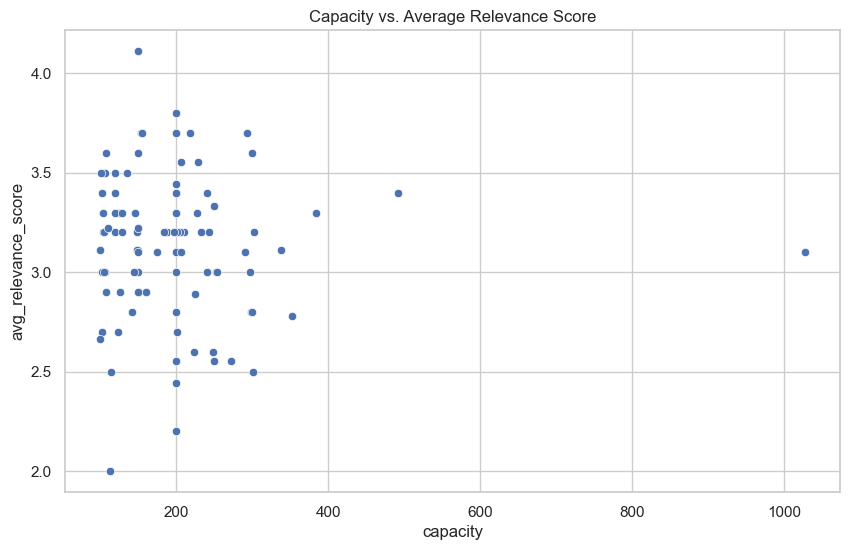

PearsonRResult(statistic=-0.02603922296716951, pvalue=0.7970536762815106)


In [145]:
# graph correlating capacity with avg_relevance_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=query, x="capacity", y="avg_relevance_score")
plt.title("Capacity vs. Average Relevance Score")
plt.show()

# what is the R^2 value of the correlation between capacity and avg_relevance_score?
from scipy.stats import pearsonr
print(pearsonr(query['capacity'], query['avg_relevance_score']))


In [146]:
query.to_csv('query_scores_code.csv', index=False)

/var/folders/m5/0x0gwbxx1kz02qrmghysp2mw0000gn/T/ipykernel_21732/2222391587.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=letters, y=avg_scores_list, palette="viridis")


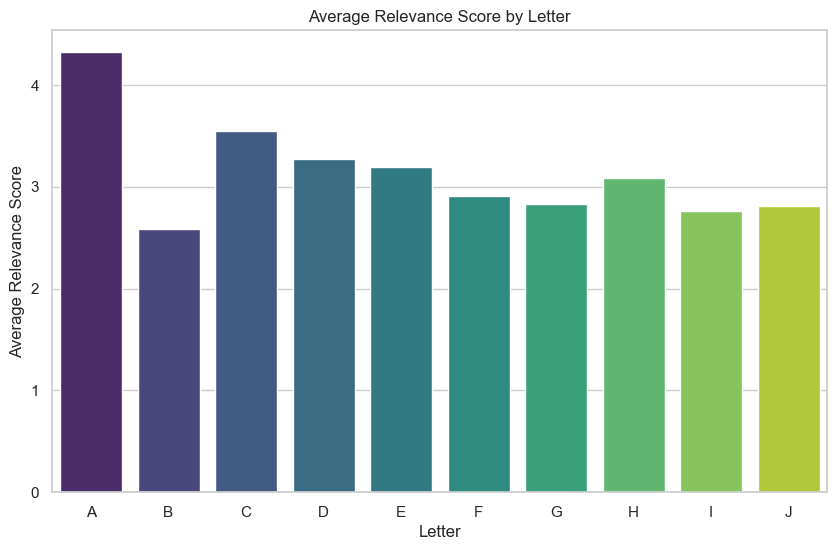

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Initialize a dictionary to hold the sum of scores and count for each letter
scores_sum = {letter: 0 for letter in "ABCDEFGHIJ"}
counts = {letter: 0 for letter in "ABCDEFGHIJ"}

# Function to extract scores and update the scores_sum and counts dictionaries
def extract_and_update_scores(relevance_scores):
    for letter in "ABCDEFGHIJ":
        # Find all occurrences of the pattern (e.g., "A=4") and sum their scores
        found_scores = re.findall(rf"{letter}=(\d)", relevance_scores)
        if found_scores:
            scores_sum[letter] += sum([int(score) for score in found_scores])
            counts[letter] += len(found_scores)

# Apply the function to each row in the 'relevance_scores' column
query['relevance_scores'].apply(extract_and_update_scores)

# Calculate the average score for each letter
avg_scores = {letter: scores_sum[letter] / counts[letter] if counts[letter] != 0 else 0 for letter in "ABCDEFGHIJ"}

# Prepare data for plotting
letters = list(avg_scores.keys())
avg_scores_list = list(avg_scores.values())

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=letters, y=avg_scores_list, palette="viridis")
plt.title("Average Relevance Score by Letter")
plt.xlabel("Letter")
plt.ylabel("Average Relevance Score")
plt.show()


In [5]:
import openai
from openai import OpenAI

messages = [
    {
        "role": "system",
        "content": (
            "You are an artificial intelligence assistant for research on conflicts around renewable energy projects in the US and you need to provide detailed, accurate responses to user questions about specific renewable energy projects."
        ),
    },
    {
        "role": "user",
        "content": (
            f"Please describe the online evidence for controversy, opposition, and support for the renewable energy project {query.iloc[2]['query'].split(' (controversy OR opposition OR lawsuit OR conflict OR hearing)')[0]}."
        ),
    },
]

client = OpenAI(api_key=os.environ["PERPLEXITY_API_KEY"], base_url="https://api.perplexity.ai")

# chat completion without streaming
response = client.chat.completions.create(
    model="mistral-7b-instruct",
    messages=messages,
)
print(response)


ChatCompletion(id='ccc089c9-564e-4ce3-a06b-58208192f2a1', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='The Eclipse Wind Farm is a renewable energy project located in Guthrie County, Iowa. The wind farm, developed by Eclipse Renewable Energy, consists of 105 wind turbines with a total capacity of 200 megawatts (MW). The project has been the subject of controversy and opposition, as well as support, since its inception.\n\nControversy and Opposition:\n\n1. Health Concerns: Some residents and opponents argue that wind turbines can cause health problems, such as headaches, dizziness, and sleep disturbances. They claim that the low-frequency noise and infrasound emitted by wind turbines can be harmful to human health. According to a report by the Iowa Department of Public Health, there is no conclusive evidence that wind turbines cause health problems in the general population. However, some individuals may be more sensitive to the noise and infrasou

In [131]:
url = "https://api.perplexity.ai/chat/completions"

payload = {
    "model": "mistral-7b-instruct",
    "messages": [
        {
            "role": "system",
            "content": "You are an artificial intelligence assistant for research on conflicts around renewable energy projects in the US and you need to provide detailed, accurate responses to user questions about specific renewable energy projects."
        },
        {
            "role": "user",
            "content": f"Please describe the online evidence for controversy, opposition, and support for the renewable energy project {query.iloc[2]['query'].split(' (controversy OR opposition OR lawsuit OR conflict OR hearing)')[0]}."
        }
    ]
}
headers = {
    "accept": "application/json",
    "content-type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)

print(response.text)

<html>
<head><title>401 Authorization Required</title></head>
<body>
<center><h1>401 Authorization Required</h1></center>
<hr><center>openresty/1.21.4.3</center>
<script defer src="https://static.cloudflareinsights.com/beacon.min.js/v84a3a4012de94ce1a686ba8c167c359c1696973893317" integrity="sha512-euoFGowhlaLqXsPWQ48qSkBSCFs3DPRyiwVu3FjR96cMPx+Fr+gpWRhIafcHwqwCqWS42RZhIudOvEI+Ckf6MA==" data-cf-beacon='{"rayId":"85c61f648c3e4cfa","b":1,"version":"2024.2.1","token":"92730c73a9e747fbb6a25e1d6657122d"}' crossorigin="anonymous"></script>
</body>
</html>



In [137]:
import openai
from openai import OpenAI
from packaging import version

required_version = version.parse("1.1.1") # replace the version by the version you want
current_version = version.parse(openai.__version__)

if current_version < required_version:
    raise ValueError(f"Error: OpenAI version {openai.__version__}"
                     " is less than the required version 1.1.1")
else:
    print("OpenAI version is compatible.")

ImportError: cannot import name 'OpenAI' from 'openai' (/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/openai/__init__.py)

In [133]:
!pip install openai==1.1.1

  Obtaining dependency information for openai==1.1.1 from https://files.pythonhosted.org/packages/f7/86/ea99e3f966a639a3256e2f79d78cd63d45d5eb651a5457ccbdcfd9eed24a/openai-1.1.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: openai
    Found existing installation: openai 1.12.0
    Uninstalling openai-1.12.0:
      Successfully uninstalled openai-1.12.0
